<a href="https://colab.research.google.com/github/RRDajay/Machine_Learning_Collection/blob/master/Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim 
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Hyperparameters
batch_size = 1000
num_epochs = 5

# Load data
transform = transforms.Compose([
                                transforms.ToTensor()
    ])

train_set = torchvision.datasets.CIFAR10(root='dataset/', train=True, transform=transform, download=True)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_set = torchvision.datasets.CIFAR10(root='dataset/', train=False, transform=transform, download=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=True)

Extracting dataset/cifar-10-python.tar.gz to dataset/
Files already downloaded and verified


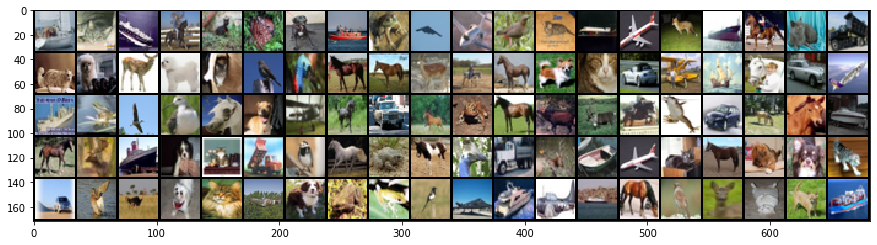

In [3]:
# Data Visuals
import numpy as np 
from matplotlib import pyplot as plt

def show(img):
    npimg = img.numpy()
    plt.figure(figsize=(15,30))
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

img_sample, _ = next(iter(train_loader))

grid = torchvision.utils.make_grid(img_sample[0:100], nrow=20)
show(grid)

In [4]:
class Identity(nn.Module):

  def __init__(self):
    super().__init__()

  def forward(self, x):
    return x


# GPU or CPU selection
device = 'cuda' if torch.cuda.is_available else 'cpu'

# Model Creation

model = torchvision.models.vgg16(pretrained=True, progress=True)
# Freeze model
for param in model.parameters():
  param.requires_grad = False

# Create new linear layer, remove avgpool layer
model.avgpool = Identity()
model.classifier = nn.Sequential(
    nn.Dropout(),
    nn.BatchNorm1d(num_features=512),
    nn.Linear(512, 10)
    )

model = model.to(device)

print(model)


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth



VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=

In [5]:
# Optimizer and Loss
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Scheduler
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, verbose=True)

In [6]:
# Model training 
n_total_steps =len(train_loader)
for epoch in range(num_epochs):

  losses = []

  for batch_idx, (data, targets) in enumerate(train_loader):
    data, targets = data.to(device), targets.to(device)

    # Forward
    scores = model(data)
    loss = criterion(scores, targets)
    losses.append(loss.item())

    # Backward
    optimizer.zero_grad()
    loss.backward()

    # Grad Descent
    optimizer.step()
    losses.append(loss.item())
    if (batch_idx) % 25 == 0:
      print(f"Epoch: {epoch+1}/{num_epochs}\t\tStep: {batch_idx+1}/{n_total_steps}\t\tloss: {sum(losses)/len(losses)}")
  
  scheduler.step(sum(losses)/len(losses)) 

Epoch: 1/5		Step: 1/50		loss: 2.463200569152832
Epoch: 1/5		Step: 26/50		loss: 2.0767000317573547
Epoch: 2/5		Step: 1/50		loss: 1.6533905267715454
Epoch: 2/5		Step: 26/50		loss: 1.5600729859792268
Epoch: 3/5		Step: 1/50		loss: 1.4943873882293701
Epoch: 3/5		Step: 26/50		loss: 1.4492508264688344
Epoch: 4/5		Step: 1/50		loss: 1.3553380966186523
Epoch: 4/5		Step: 26/50		loss: 1.4078556574307954
Epoch: 5/5		Step: 1/50		loss: 1.375479817390442
Epoch: 5/5		Step: 26/50		loss: 1.3908496178113496


In [7]:
# Model Validation
def model_validation(loader):
  
  if loader.dataset.train is True:
    print("Training dataset will be used for validation...")

  else:
    print("Testing dataset will be used for validation...")

  with torch.no_grad():

    n_correct, n_samples = 0, 0

    for data, labels in test_loader:
      
      data = data.to(device)
      labels = labels.to(device)
      
      outputs = model(data)
      _, predictions = torch.max(outputs, 1)
      n_samples += labels.shape[0]
      n_correct += (predictions == labels).sum().item()

    acc = 100 * n_correct/n_samples
    
    print(f"\tAccuracy: {acc}")

model_validation(train_loader)
model_validation(test_loader)


Training dataset will be used for validation...
	Accuracy: 51.76
Testing dataset will be used for validation...
	Accuracy: 51.88


torch.Size([1000, 3, 32, 32])

In [8]:
# TODO:
# Apply normalization to image dataset
# Apply augmentation to image dataset
# Tensorboard 
# Improve validation code